# ML course : Assignment 3 ,  flowers classification with CNN using VGG19
https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

In [1]:

import numpy as np
import scipy.io
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, MaxPool2D,BatchNormalization,Dropout
from keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

HOME_DIR = '/sise/home/yanaiom/Machine_Learning/ML_AS3/flower102_vgg/'           ### Modify this according to your local env.
IMAGES_DIR = HOME_DIR+'jpg/'
img_width, img_height = 224, 224
batch_size = 8
LR=0.0001

## downloading dataset

In [2]:
home_exists = os.path.exists(HOME_DIR)
if not home_exists:
  !mkdir $HOME_DIR

In [3]:
%cd $HOME_DIR

/sise/home/yanaiom/Machine_Learning/ML_AS3/flower102_vgg


In [4]:
jpg_exists = os.path.exists(IMAGES_DIR)
if not jpg_exists:
    !wget 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz' --no-check-certificate
    !wget 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat' --no-check-certificate
    !tar -xzf '102flowers.tgz'


## labels preprocessing

In [5]:
mat = scipy.io.loadmat(HOME_DIR+'imagelabels.mat')     # read labels from a MATLAB format to Array
labels=mat['labels'].reshape(-1,1).tolist()
print(min(labels),max(labels))
print(list(np.unique(np.array(labels))))

[1] [102]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102]


In [6]:
# prepare  list of images
print(len(labels),' images exist')
image_list= sorted(os.listdir(IMAGES_DIR))
image_list[:5]

8189  images exist


['image_00001.jpg',
 'image_00002.jpg',
 'image_00003.jpg',
 'image_00004.jpg',
 'image_00005.jpg']

In [7]:
# prepare list of images with labels, and df_y
l=[]
y=[]
for idx,i in enumerate(image_list):
  current_idx=int(i.split('_')[1][:5])

  if idx+1 != current_idx:
    assert ('indexing of images and labels do not match ')
  current_label=labels[idx][0]    #   labels are between 1-102 will be LAbelEncoded later
  l.append([idx,i,current_label])
  y.append(current_label)

df_y=pd.DataFrame(y,columns=['label'])
num_classes=df_y['label'].nunique()
print(l[:5])
print('num_classes=',num_classes)

[[0, 'image_00001.jpg', 77], [1, 'image_00002.jpg', 77], [2, 'image_00003.jpg', 77], [3, 'image_00004.jpg', 77], [4, 'image_00005.jpg', 77]]
num_classes= 102


In [8]:
#save mapping of image_files to labels to csv
df= pd.DataFrame(l,columns=['id','filename','label'])
df.drop('id',axis=1,inplace=True)
df.to_csv('flower102_labels.csv',index=False)

In [9]:
list_of_labels = [str(i) for i in range(1,103)]
print(list_of_labels)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102']


# VGG

48 images of label 102 ['image_08000.jpg', 'image_08001.jpg', 'image_08002.jpg', 'image_08003.jpg', 'image_08004.jpg', 'image_08005.jpg', 'image_08006.jpg', 'image_08007.jpg', 'image_08008.jpg', 'image_08009.jpg', 'image_08010.jpg', 'image_08011.jpg', 'image_08012.jpg', 'image_08013.jpg', 'image_08014.jpg', 'image_08015.jpg', 'image_08016.jpg', 'image_08017.jpg', 'image_08018.jpg', 'image_08019.jpg', 'image_08020.jpg', 'image_08021.jpg', 'image_08022.jpg', 'image_08023.jpg', 'image_08024.jpg', 'image_08025.jpg', 'image_08026.jpg', 'image_08027.jpg', 'image_08028.jpg', 'image_08029.jpg', 'image_08030.jpg', 'image_08031.jpg', 'image_08032.jpg', 'image_08033.jpg', 'image_08034.jpg', 'image_08035.jpg', 'image_08036.jpg', 'image_08037.jpg', 'image_08038.jpg', 'image_08039.jpg', 'image_08040.jpg', 'image_08041.jpg', 'image_08042.jpg', 'image_08043.jpg', 'image_08044.jpg', 'image_08045.jpg', 'image_08046.jpg', 'image_08047.jpg']
label 77 224 224
label 77 224 224
label 77 224 224
label 77 224 

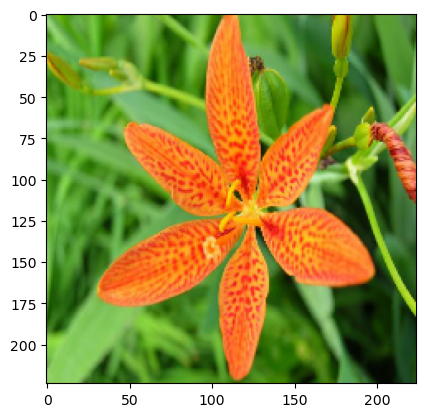

In [10]:
# #####  verification that label and image match
target_label=102
flower102 = [i[1] for i in l if i[2]==target_label ]
print(len(flower102),'images of label',target_label,flower102)
for i in range(5):
  image_file = IMAGES_DIR + flower102[i]
  image = load_img(image_file,target_size=(img_width, img_height))
  print('label',y[i],image.width,image.height)
  plt.imshow(image)

In [11]:
# # load all images to array
arr=[]
for i in image_list:
  image_file = IMAGES_DIR + i
  image = load_img(image_file,target_size=(img_width, img_height))
  input_arr = img_to_array(image)
  arr.append(input_arr)
X = np.array(arr)

In [12]:
# Convert labels to zero-based indexing
Y = df_y.values.flatten() - 1  # Subtracting 1 to shift from 1-based indexing to 0-based indexing

# Convert categorical labels to one-hot encoded vectors
Y_HOT = to_categorical(Y)

# Split the data into training and testing subsets
# x_ids: Input samples indices (since splitting on X crashes the notebook), Y_HOT: One-hot encoded labels matrix
x_ids = list(range(len(X)))
X_train_idx, X_test_idx, y_train, y_test = train_test_split(x_ids, Y_HOT, stratify=Y_HOT, test_size=0.25, random_state=SEED, shuffle=True)
# Further split the training subset into training and validation subsets
X_train_idx, X_valid_idx, y_train, y_valid = train_test_split(X_train_idx, y_train, test_size=0.33, random_state=SEED, shuffle=True)

# Extracting samples from X
X_train, X_valid, X_test = [], [], []
for i in X_train_idx:
  X_train.append(X[i])
for j in X_valid_idx:
  X_valid.append(X[j])
for k in X_test_idx:
  X_test.append(X[k])

In [13]:
# print('df_y',df_y.shape, df_y[-2:])
# print('Y',Y.shape,Y[-2:])
# print('Y_HOT',Y_HOT.shape,Y_HOT[-2:])

In [14]:
# print(y_train[:20].argmax(axis=1))
# print(y_valid[:20].argmax(axis=1))
# print(y_test[:20].argmax(axis=1))

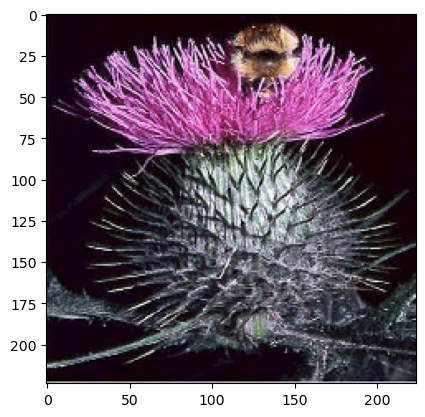

In [15]:
image=array_to_img(X_test[0])
plt.imshow(image)

In [16]:
# X_train = X_train.astype('float32') /255
# X_valid = X_valid.astype('float32') /255
# X_test = X_test.astype('float32') /255

X_test = preprocess_input(np.array(X_test))
X_valid = preprocess_input(np.array(X_valid))
X_train = preprocess_input(np.array(X_train))

print('train',X_train.shape,y_train.shape)
print('valid',X_valid.shape,y_valid.shape)
print('test',X_test.shape,y_test.shape)

train (4114, 224, 224, 3) (4114, 102)
valid (2027, 224, 224, 3) (2027, 102)
test (2048, 224, 224, 3) (2048, 102)


In [17]:
# Load the VGG19 model without the top layers (include_top=False)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

2023-07-18 11:39:46.501688: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 11:39:47.810129: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9636 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:af:00.0, compute capability: 7.5


In [18]:
# Freeze the pre-trained layers
base_model.trainable = False

base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
CONFIG = 4      #  select the CONFIG (1-4) you want to evaluate.   #3 yielded best results

In [20]:
# Option 1 :  test accurcy 0.59

if CONFIG==1:
    model = Sequential([
        base_model,
        MaxPool2D((2,2) , strides = 2),
        Flatten(),
        Dense(num_classes , activation='softmax')])

    # model.summary()
    EPOCHS = 10

In [21]:
# Option 2 :  test accuracy 0.79 after 10 epochs

if CONFIG==2:
    # flatten the output of the convolutional part:
    x = Flatten()(base_model.output)
    # three hidden layers
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(1000, activation='relu')(x)

    predictions = Dense(num_classes, activation='softmax')(x)

    # creating the full model:
    model = Model(inputs=base_model.input, outputs=predictions)
    # model.summary()
    EPOCHS = 18

In [22]:
# # Option 3 :  Allow fine tuning of base model , only final dense layer with softmax
if CONFIG==3:
    base_model.trainable = True
    x = Flatten()(base_model.output) #Output obtained on vgg19 is now flattened.
    prediction = Dense(num_classes, activation='softmax')(x) # We have 102 classes, and so, the prediction is being done
    #Creating model object
    model = Model(inputs=base_model.input, outputs=prediction)
    # model.summary()
    EPOCHS = 40

In [23]:
# Option 4 :  pooling+batchnorm+ final dense layer + dropout + softmax
if CONFIG==4:
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    prediction = Dense(num_classes, activation='softmax')(x) # We have 102 classes, and so, the prediction is being done
    #Creating model object
    model = Model(inputs=base_model.input, outputs=prediction)
    # model.summary()
    EPOCHS = 50

In [24]:
# # # option 5 : avgpooling + 1 dense layer with RELU,
# 0.8669
# Add custom top layers for flower classification
if CONFIG==5:
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(102, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    # print(model.summary())
    # from keras.utils.vis_utils import plot_model
    # plot_model(model, to_file='vgg.png')
    EPOCHS = 40

In [25]:
print('running CONFIG',CONFIG)
print(model.summary())
# Compile the model
model.compile(optimizer=Adam(learning_rate=LR),  loss='categorical_crossentropy', metrics=['accuracy'])

running CONFIG 4
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 

In [26]:
from keras.callbacks import  ReduceLROnPlateau, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor=0.1,
                              patience=5,
                              verbose=1,
                              mode="auto",
                              min_delta=0.0001,
                              cooldown=0,
                              min_lr=0.00001
                              )
mcp_save = ModelCheckpoint(filepath = HOME_DIR+str(CONFIG)+'best.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

In [27]:
tf.config.optimizer.set_jit(True)
history=model.fit(X_train, y_train, batch_size=batch_size , callbacks=[reduce_lr,mcp_save],
                  validation_data=(X_valid, y_valid), epochs=EPOCHS)

2023-07-18 11:39:53.610467: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2477088768 exceeds 10% of free system memory.
2023-07-18 11:39:57.670086: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2477088768 exceeds 10% of free system memory.
2023-07-18 11:40:01.403058: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2023-07-18 11:40:02.398043: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.
2023-07-18 11:40:03.931431: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8401


  3/515 [..............................] - ETA: 17s - loss: 5.3602 - accuracy: 0.0417    

2023-07-18 11:40:10.241416: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.
2023-07-18 11:40:10.317048: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.


515/515 [==============================] - ETA: 0s - loss: 4.0922 - accuracy: 0.1310

2023-07-18 11:40:28.169934: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1220481024 exceeds 10% of free system memory.
2023-07-18 11:40:30.156111: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1220481024 exceeds 10% of free system memory.
2023-07-18 11:40:32.331704: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.
2023-07-18 11:40:32.443894: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.


515/515 [==============================] - 39s 58ms/step - loss: 4.0922 - accuracy: 0.1310 - val_loss: 3.1309 - val_accuracy: 0.3463
Epoch 2/50
515/515 [==============================] - 23s 44ms/step - loss: 2.7088 - accuracy: 0.4064 - val_loss: 2.2583 - val_accuracy: 0.5244
Epoch 3/50
515/515 [==============================] - 24s 47ms/step - loss: 1.9479 - accuracy: 0.5741 - val_loss: 1.7377 - val_accuracy: 0.6522
Epoch 4/50
515/515 [==============================] - 24s 47ms/step - loss: 1.5023 - accuracy: 0.6743 - val_loss: 1.3943 - val_accuracy: 0.7104
Epoch 5/50
515/515 [==============================] - 24s 47ms/step - loss: 1.1550 - accuracy: 0.7496 - val_loss: 1.1720 - val_accuracy: 0.7499
Epoch 6/50
515/515 [==============================] - 24s 47ms/step - loss: 0.9259 - accuracy: 0.7985 - val_loss: 1.0171 - val_accuracy: 0.7775
Epoch 7/50
515/515 [==============================] - 25s 48ms/step - loss: 0.7742 - accuracy: 0.8313 - val_loss: 0.9045 - val_accuracy: 0.7933
Epo

In [28]:
# # reload the model (epoch) that got best accuracy
from keras.models import load_model
best_model = load_model(HOME_DIR+str(CONFIG)+'best.hdf5')

In [29]:
# Evaluate the model on the test data
scores = best_model.evaluate(X_test, y_test, batch_size=batch_size)
#scores = model.evaluate(test_generator.flow(X_test, y_test, batch_size=batch_size))
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

2023-07-18 12:01:03.677673: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1233125376 exceeds 10% of free system memory.


  3/256 [..............................] - ETA: 7s - loss: 0.4637 - accuracy: 0.9167  

2023-07-18 12:01:08.193425: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.
2023-07-18 12:01:08.282924: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.


256/256 [==============================] - 8s 28ms/step - loss: 0.5122 - accuracy: 0.8711
Test loss: 0.5122096538543701
Test accuracy: 0.87109375


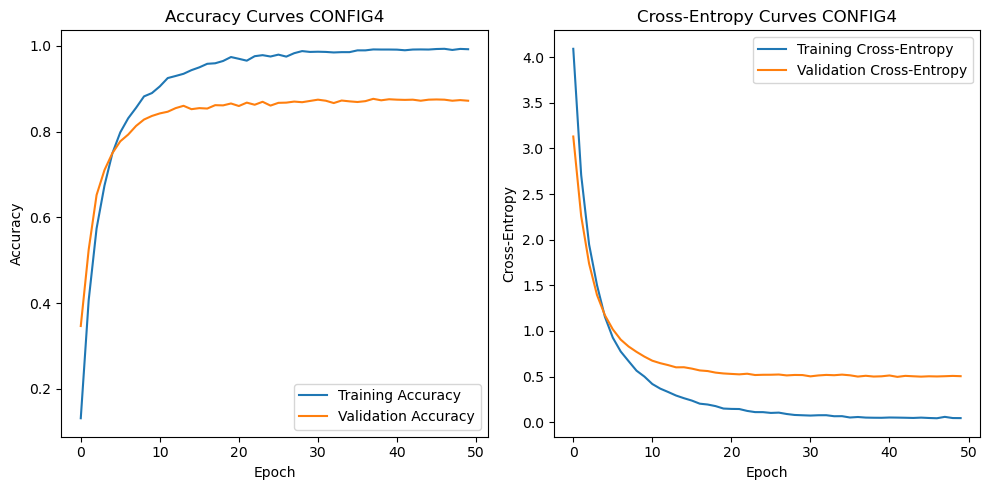

In [30]:
# from matplotlib import pyplot as plt
# Plot accuracy graph
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves CONFIG'+str(CONFIG))
plt.legend()

# Plot cross-entropy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Cross-Entropy')
plt.plot(history.history['val_loss'], label='Validation Cross-Entropy')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy')
plt.title('Cross-Entropy Curves CONFIG'+str(CONFIG))
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
y_pred = best_model.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

2023-07-18 12:01:22.061514: W tensorflow/compiler/jit/kernels/xla_ops.cc:436] Compilation failed:Unimplemented: Could not find compiler for platform CUDA: Not found: could not find registered compiler for platform CUDA -- check target linkage (hint: try adding tensorflow/compiler/jit:xla_gpu_jit as a dependency).  Falling back to TF function call.
2023-07-18 12:01:22.899349: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


Text(0.5, 23.52222222222222, 'Predicted label')

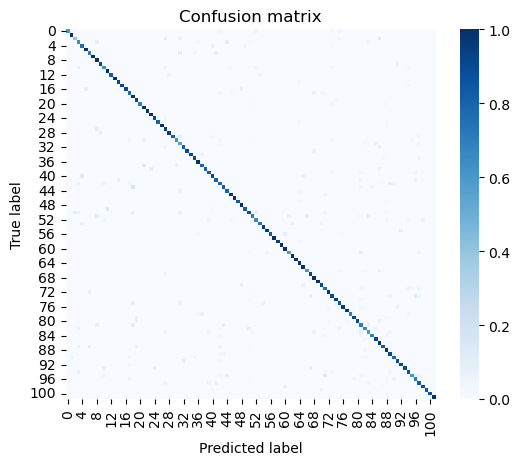

In [32]:
# # axis_labels = list(CLASSES.values())
import seaborn as sns
confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)

# Create the heatmap using seaborn
ax = sns.heatmap(confusion_normalized, cmap='Blues', square=True)
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")

In [33]:
# free memory
# del X
# del arr
# del X_train
# del X_valid
# del X_test
# del model
# del history